# Your name:

# Starter Code

This notebook implements starter code to help you get started with the assignment. If you have a personal GPU, copy this starter code to another directory and run this notebook using your personal GPU. In that case, the docker we provide will not support PyTorch with GPU, and you can create your own virtual environment (e.g., conda) with PyTorch support (https://pytorch.org/get-started/locally/). 

To run this notebook you must __first create a folder called `./dataset` and download all the data files from the Kaggle competition page__.

In [284]:
import time
import os

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.optim as optim
%matplotlib inline


params = {
    'log_interval': 1000,
    'epochs': 10
}

In [285]:
# GPU setup
use_cuda = torch.cuda.is_available()
print("Using {}".format('GPU' if use_cuda else 'CPU'))

Using GPU


## Load the dataset

Read the class labels from the train_labels.csv file

In [286]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def read_labels(label_file):
    labels = np.zeros(50000).astype(np.uint8)
    with open(label_file, 'r') as f:
        n, header_seen = 0, False
        for line in f:
            if not header_seen:
                header_seen = True
                continue
            labels[n] = int(line.strip().split(',')[1])
            n += 1
    return labels

train_val_labels = read_labels("dataset/train_labels.csv")

In [287]:
train_val_images = np.load("dataset/train_data.npy")
# train_val_images = np.transpose(train_val_images, (0,3,1,2))
train_val_images.shape

(50000, 3, 32, 32)

Load training and validation image datasets

Split the training dataset into a training and validation sets

In [288]:
train_labels = train_val_labels[:40000]
val_labels = train_val_labels[40000:]
all_labels = {'train': train_labels, 'validation': val_labels}

train_images = train_val_images[:40000]
val_images = train_val_images[40000:]
all_images = {'train': train_images, 'validation': val_images}

Visualize a few sample training images

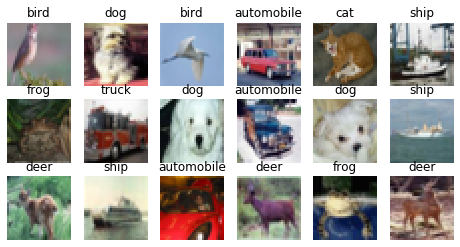

In [289]:
plt.figure(1, figsize=(8,4))

train_to_plot = np.transpose(train_images, (0,2,3,1))
H, W = 6, 3
for y in range(H):
    for x in range(W):
        n = y*W+x
        plt.subplot(W,H,n+1)
        plt.imshow(train_to_plot[n, :, :, :])
        plt.title("%s" % (class_names[train_labels[n]]))
        plt.axis('off')

## Network Definition

Starter code to set up the network and optimizer (from the PyTorch tutorial page). You will almost certainly need to use a better network topology here. Also, copy the network definition to `network-profile.ipynb` and run the energy/latency estimation.

Starter code to set up the network and optimizer (from the PyTorch tutorial page). You will almost certainly need to use a better network topology here.

In [290]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.conv1_bn = nn.BatchNorm2d(12)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(48, 64, 5)
        self.conv2_bn = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.conv3_bn = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(128 * 8 * 8, 120)
        self.fc1_bn = nn.BatchNorm1d(120)        
        self.dropout1 = nn.Dropout(p=0.5)        
        self.fc2 = nn.Linear(120, 84)
        self.fc2_bn = nn.BatchNorm1d(84)
        self.dropout2 = nn.Dropout(p=0.5)        
        self.fc3 = nn.Linear(84, 84)
        self.fc3_bn = nn.BatchNorm1d(84)
        self.dropout3 = nn.Dropout(p=0.5)        
        self.fc4 = nn.Linear(84, 10)
        self.fc4_bn = nn.BatchNorm1d(10)
        self.dropout4 = nn.Dropout(p=0.5)        

        
    def forward(self, x):
        x = self.pool(F.relu((self.conv1(x))))
        x = F.relu((self.conv2(x)))
        x = F.relu((self.conv3(x)))
        x = x.view(-1, 128 * 8 * 8)
        #x = self.dropout1(x)
        x = F.relu((self.fc1(x)))
        x = F.relu((self.fc2(x)))
        x = (self.fc3(x))
        x = ((self.fc4(x)))
        return x


net = Net()

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
#optimizer = optim.Adam([var1, var2], lr=0.0001)

## Train the network

In [291]:
trainset = torch.from_numpy(np.expand_dims(train_images, axis=1))
train_labels_torch = torch.from_numpy(train_labels)

valset = torch.from_numpy(np.expand_dims(val_images, axis=1))
val_labels_torch = torch.from_numpy(val_labels)

num_train = len(trainset)
indices = list(range(num_train))
split = 10000

# shuffle data
np.random.seed(6825)
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=50, sampler=train_sampler, shuffle=False)

validloader = torch.utils.data.DataLoader(trainset, batch_size=50, sampler=valid_sampler, shuffle=False)

testloader = torch.utils.data.DataLoader(testset, batch_size=50, shuffle=False)

NameError: name 'SubsetRandomSampler' is not defined

In [ ]:
# convert numpy arrays to format required for pytorch

train_images_torch = torch.from_numpy(np.expand_dims(train_images, axis=1))
train_images_torch = (train_images_torch/255.0)*2.0-1 # normalization [-1 to 1]
train_labels_torch = torch.from_numpy(train_labels)

val_images_torch = torch.from_numpy(np.expand_dims(val_images, axis=1))
val_images_torch = (val_images_torch/255.0)*2.0-1 # normalization [-1 to 1]
val_labels_torch = torch.from_numpy(val_labels)

# initialize weights and biases
nn.init.kaiming_uniform_(net.conv1.weight, nonlinearity = 'relu')
stdv = 1./np.sqrt(net.conv1.bias.size(0))
nn.init.uniform_(net.conv1.bias, -stdv, stdv)
nn.init.kaiming_uniform_(net.conv2.weight, nonlinearity = 'relu')
stdv = 1./np.sqrt(net.conv2.bias.size(0))
nn.init.uniform_(net.conv2.bias, -stdv, stdv)
nn.init.kaiming_uniform_(net.fc1.weight, nonlinearity = 'relu')
stdv = 1./np.sqrt(net.fc1.bias.size(0))
nn.init.uniform_(net.fc1.bias, -stdv, stdv)
nn.init.kaiming_uniform_(net.fc2.weight, nonlinearity = 'relu')
stdv = 1./np.sqrt(net.fc2.bias.size(0))
nn.init.uniform_(net.fc2.bias, -stdv, stdv)
nn.init.kaiming_uniform_(net.fc3.weight, nonlinearity = 'relu')
stdv = 1./np.sqrt(net.fc2.bias.size(0))
nn.init.uniform_(net.fc2.bias, -stdv, stdv)

training_error_log = np.zeros(int(params['epochs']*train_images_torch.shape[0]/params['log_interval']))
training_loss_log = np.zeros(int(params['epochs']*train_images_torch.shape[0]/params['log_interval']))
valid_error_vect = np.zeros(params['epochs'])

if use_cuda:
    net.cuda()
    criterion.cuda()

#optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(net.parameters() , lr=0.005)

# train
for epoch in range(params['epochs']):  # loop over the dataset multiple times

    total_train = 0
    correct_train = 0
    
    correct_val = 0
    total_val = 0

    running_loss = 0.0
    for i in range(train_images_torch.shape[0]):
        # get the inputs; data is a list of [inputs, labels]
        inputs = train_images_torch[i].float()
        labels = train_labels_torch[i].long()
        labels = labels.unsqueeze(0)
        #print(labels)
        if use_cuda:
            inputs, labels = inputs.cuda(), labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        training_error = 1 - correct_train / total_train
        if i % params['log_interval'] == params['log_interval']-1:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f, training error: %.1f%%' % 
                  (epoch + 1, i + 1, running_loss / params['log_interval'], training_error*100))
            training_loss_log[int((epoch*train_images_torch.shape[0]/params['log_interval'])+(i+1)/params['log_interval']-1)] = running_loss/params['log_interval']
            training_error_log[int((epoch*train_images_torch.shape[0]/params['log_interval'])+(i+1)/params['log_interval']-1)] = training_error
            running_loss = 0.0
    
    # calculate validation accuracy after every epoch
    with torch.no_grad():
        for i in range(val_images_torch.shape[0]):
            images = val_images_torch[i].float()
            labels = val_labels_torch[i].long()
            labels = labels.unsqueeze(0)
            if use_cuda:
                images, labels = images.cuda(), labels.cuda()
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            
    print('Error on validation set after epoch %d: %.1f %%' % (epoch+1,
    100*(1 - correct_val / total_val)))
    valid_error = 1 - correct_val / total_val
    valid_error_vect[epoch] = valid_error

print('Finished Training')


## Test the network

Some metrics from training

In [ ]:
plt.figure(1)
plt.plot(np.arange(training_loss_log.size)*params['log_interval'], training_loss_log, 'o')

plt.figure(2)
plt.plot(np.arange(training_error_log.size)*params['log_interval'], training_error_log, '-o')
plt.plot(np.arange(valid_error_vect.size)*train_images_torch.shape[0]+train_images_torch.shape[0], valid_error_vect, '-o')

print("Final Training Accuracy: %g%%" % ((1-training_error_log[-1])*100))
print("Final Validation Accuracy: %g%%" % ((1-valid_error_vect[-1])*100))

Save model

In [ ]:
MODELPATH = './cifar10_sample.pth.tar'
torch.save(net.state_dict(), MODELPATH)

In [ ]:
sum(p.numel() for p in net.parameters() if p.requires_grad)

## Estimate assignment grade on validation set

Run the network profiler in `network-profile.ipynb` using your model description. Then copy your result into the network_complexity dictionary below. Please check the unit conversion, and round the value to four decimal places.

In [ ]:
network_complexity = {}
network_complexity['energy'] = 0.12881117 # Estimated energy in mJ.
network_complexity['latency'] = 0.03135800 # Number of cycles in Million (1e6).
network_complexity['activation'] = 49920 # Activation size in byte. 

In [ ]:
accuracy = 1-valid_error_vect[-1]
def get_score(accuracy, network_complexity):
    error_rate = (1-accuracy) * 100
#    error_rate = 20
    print(str(error_rate))
    loss = error_rate / 12 + network_complexity['latency'] / 0.3
    
    if error_rate > 50:
        return (0, loss)
    elif network_complexity['activation'] > 1000000:
        return (0, loss)
    else:
        score = 0
        if network_complexity['energy'] > 2:
            score += 0
        elif network_complexity['energy'] > 1.5:
            score += 5
        elif network_complexity['energy'] > 1:
            score += 10
        elif network_complexity['energy'] > 0.5:
            score += 15
        else:
            score += 20
            
        if network_complexity['latency'] > 1:
            score += 0
        elif network_complexity['latency'] > 0.5:
            score += 5
        elif network_complexity['latency'] > 0.25:
            score += 10
        elif network_complexity['latency'] > 0.1:
            score += 15
        else:
            score += 20
            
        if error_rate < 5:
            score += 80
        elif error_rate < 10:
            score += 70
        elif error_rate < 20:
            score += 60
        elif error_rate < 30:
            score += 50
        elif error_rate < 40:
            score += 40
        else:
            score += 30
            
        return (score, loss)

base_score, loss = get_score(accuracy, network_complexity)
    
# Calculated at the end of the competition based on everyones loss
competition_bonus = 0
final_score = base_score + (competition_bonus if base_score > 0 else 0)

print("Base Score: %d, Loss: %g" % (base_score, loss))
print("Final Score: %d" % (final_score))

## Generate a Kaggle submission file

In [ ]:
import datetime

def create_submission(labels):
    now = time.time()
    now_str = datetime.datetime.fromtimestamp(now).strftime('%m%d-%H%M%S')
    complexity_str = '{:.4f}-{:.4f}-{}'.format(network_complexity['energy'], \
                                               network_complexity['latency'], \
                                               network_complexity['activation']).replace('.', 'p')
    filename = 'submission-%s-%s.csv' % (complexity_str, now_str)
    with open(filename, 'w') as f:
        f.write("Id,Prediction\n")
        for n in range(labels.shape[0]):
            f.write("%d,%d\n" % (n,labels[n]))
    return now_str, filename

test_images = np.load("dataset/test_data.npy")

# convert to torch format
test_images = torch.from_numpy(np.expand_dims(test_images, axis=1))
test_result = torch.zeros(test_images.shape[0])

# test on validation data
with torch.no_grad():
    for i in range(test_images.shape[0]):
        images = test_images[i]
        images = (images/255.0)*2.0-1 # normalization [-1 to 1]
        images = images.float() # convert to torch format
        if use_cuda:
            images =images.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        test_result[i] = predicted
        if i % 10000 == 9999:
            print('Test data processed: %d/300000' % (i+1))

now_str, filename = create_submission(test_result.numpy())